In [9]:
from models import ALSRecommender, PopRecommender
from evaluation import evaluate
from processing import *
from utils import IDMAP
import pandas as pd
import seaborn as sb

### process

In [10]:
path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\data\Ratings.csv\Ratings.csv"
data = pd.read_csv(path)

# remove samples with less than minimum_interaction
processed_data = filter_by_num_interactions(data, "User-ID", "ISBN", minimum_interaction = 10)
processed_data = filter_by_num_interactions(processed_data, "ISBN", "User-ID", minimum_interaction = 10)
processed_data = filter_by_num_interactions(processed_data, "User-ID", "ISBN", minimum_interaction = 10)
processed_data = filter_by_num_interactions(processed_data, "ISBN", "User-ID", minimum_interaction = 10)
# add column containing all ones
processed_data = add_interaction_column(processed_data)
# train_test_split
train, test = train_test_split(processed_data, train_frac = 0.7, seed = 0)
# convert to csr interaction matrix i.e input to model
train_csr, users, items = df2interact_mat(df = train, user_col = 'User-ID', item_col = "ISBN", interact_col = "interaction")
# retain a mapping between userids, itemids and their indexes in the recommender model
user_map = IDMAP(users)
item_map = IDMAP(items)

In [7]:
model_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\code\models\test0"
config_dict = {
    "factors":64, 
    "regularization":0.01, 
    "alpha":1.0, 
    "iterations" : 20,
    "calculate_training_loss":True,
    "random_state":0
}
model_name = "AlternatingLeastSquares"

### tune alpha

In [8]:
alpha_values = [0.1,0.5,1.0,1.5,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
results = {}
for alpha in alpha_values:
    config_dict["alpha"] = alpha
    # train 
    model = ALSRecommender(model_name, config_dict, train_csr, user_map, item_map)
    model.fit()
    # evaluate
    results[f"alpha_{alpha}"] = evaluate(model, test)

C:\Users\tanch\anaconda3\envs\dp\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1271.97it/s]


In [23]:
alpha_values = [3.0,4.0]
for alpha in alpha_values:
    config_dict["alpha"] = alpha
    # train 
    model = ALSRecommender(model_name, config_dict, train_csr, user_map, item_map)
    model.fit()
    # evaluate
    results[f"alpha_{alpha}"] = evaluate(model, test)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1001.93it/s]


In [24]:
results

{'alpha_0.1': 0.03249046014161615,
 'alpha_0.5': 0.04880476972244459,
 'alpha_1.0': 0.06206055565473934,
 'alpha_1.5': 0.06787283242661013,
 'alpha_2.0': 0.07392524148348487,
 'alpha_5.0': 0.08662265637516443,
 'alpha_10': 0.08494840822321784,
 'alpha_7.0': 0.0738528162114286,
 'alpha_8.0': 0.07927266258652564,
 'alpha_9.0': 0.08085138384649088,
 'alpha_6.0': 0.0811522128229319,
 'alpha_3.0': 0.07889441868080446,
 'alpha_4.0': 0.0752074248628338}

<AxesSubplot:>

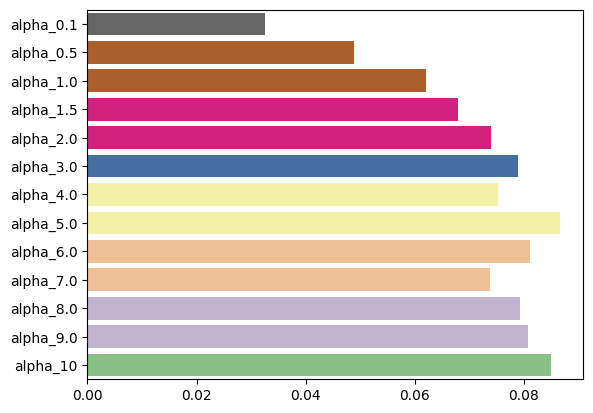

In [25]:
y = ['alpha_0.1', 'alpha_0.5', 'alpha_1.0', 'alpha_1.5', 'alpha_2.0', 'alpha_3.0', 'alpha_4.0', 'alpha_5.0', 'alpha_6.0', 'alpha_7.0', 'alpha_8.0', 'alpha_9.0', 'alpha_10']
x = [results[alpha] for alpha in y ]
sb.barplot(y = y, x =  x, palette = "Accent_r")

### tune dimensions

In [30]:
config_dict = {
    "factors":None, 
    "regularization":0.01, 
    "alpha":5.0, 
    "iterations" : 20,
    "calculate_training_loss":True,
    "random_state":0
}

In [31]:
factor_values = [16,32,64,100,128,256]
results = {}
for factors in factor_values:
    config_dict["factors"] = factors
    # train 
    model = ALSRecommender(model_name, config_dict, train_csr, user_map, item_map)
    model.fit()
    # evaluate
    results[f"factors_{factors}"] = evaluate(model, test)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 875.61it/s]


In [32]:
results

{'factors_16': 0.0650027839190787,
 'factors_32': 0.07657279563244752,
 'factors_64': 0.07975592906353837,
 'factors_100': 0.08248291144269039,
 'factors_128': 0.08935284161679342,
 'factors_256': 0.09701352183837234}

<AxesSubplot:>

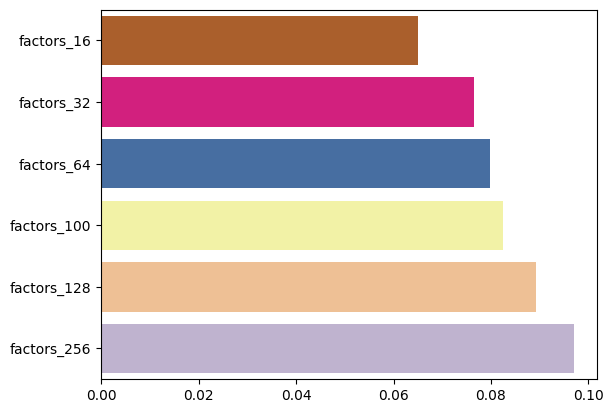

In [33]:
sb.barplot(y = list(results.keys()), x =  list(results.values()), palette = "Accent_r")

### retrain and save best

In [10]:
model_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\code\models\final_recommender"
config_dict = {
    "factors":128, 
    "regularization":0.01, 
    "alpha":5.0, 
    "iterations" : 30,
    "calculate_training_loss":True,
    "random_state":0
}
model_name = "AlternatingLeastSquares"

In [11]:
# train 
model = ALSRecommender(model_name, config_dict, train_csr, user_map, item_map)
model.fit(show_progress = True)

100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:29<00:00,  1.01it/s, loss=0.0069]


In [12]:
evaluate(model, test)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1123.56it/s]


0.084719441155672

In [13]:
# save model
model.save(model_path)

In [9]:

# load model
model = ALSRecommender(config_dict, train_csr, user_map, item_map)
model.load(model_path)

### save pickling other objects

In [15]:
import pickle
import os
directory = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\code\models"
with open(os.path.join(directory,"item_map.pkl"),"wb") as f:
    pickle.dump(item_map, f)

In [16]:
with open(os.path.join(directory,"user_map.pkl"),"wb") as f:
    pickle.dump(user_map, f)
with open(os.path.join(directory,"train_csr.pkl"),"wb") as f:
    pickle.dump(train_csr, f)